# Simple showcase of basic optimization of analytical functions

### Single objective

solution = top_x: Real[-0.0008559010141209037, 0.001627663254195255]
top_f: 3.381854215030679e-6
penalty: 0.0



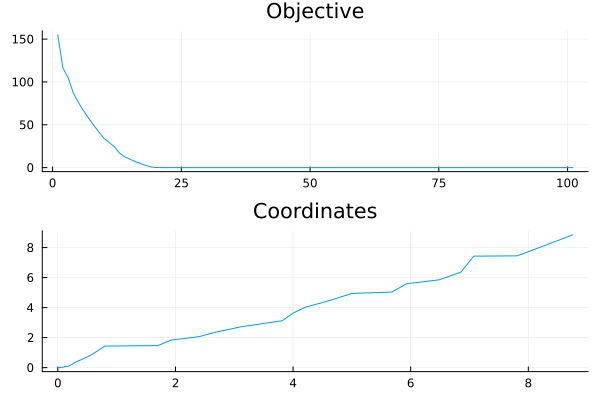

In [2]:
using EO

dims = 2
pop_size = 100
objective_function  = enclose_arguments(f_sphere, zeros(dims))  # min at origin
initialization      = enclose_noargs(interval_real_initialization, dims, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, pop_size, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_keep_best_n, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)
solution            = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)
@show solution
EO.plot_results(solution, "simple")

solution = top_x: Real[154.0285759972713, -18.589226443419236]
top_f: -1586.053439302971
penalty: 0.0



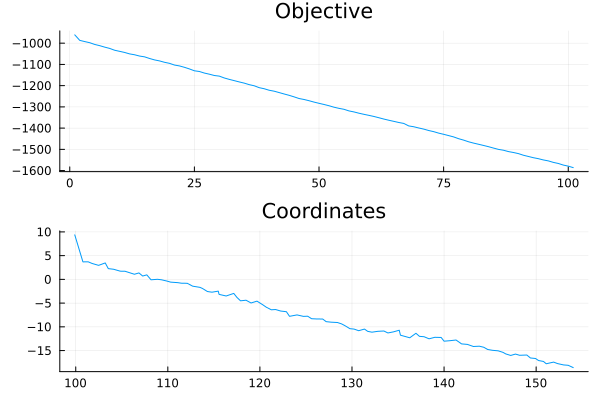

In [3]:
using EO

dims = 2
pop_size = 100
objective_function  = enclose_arguments(f_linear, [10, -10, 3]) # linear combination with coefs 10 -10 and bias 3 
initialization      = enclose_noargs(interval_real_initialization, dims, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, pop_size, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_keep_best_n, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)
solution            = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)
@show solution
EO.plot_results(solution, "simple")

### Multiple objectives

solution = top_x: Real[0.004970202237511476, 0.01777788515949892]
top_f: 1.9548445813170052
penalty: 0.06753807935887579



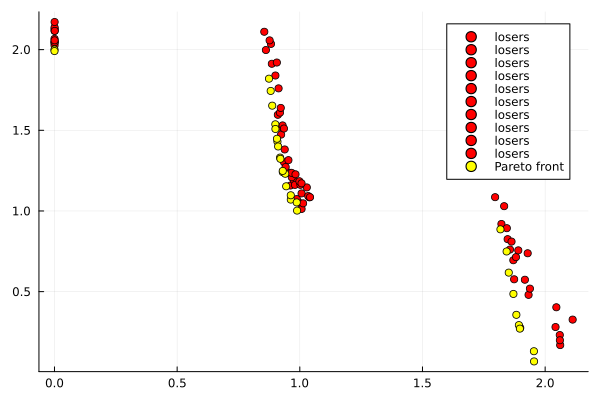

In [5]:
pop_size = 100
dimension = 2

F = typeof(enclose_arguments(EO.f_weighted_sum, ones(dimension)))
objective_function  = EO.MultiObjFunction{F}([enclose_arguments(EO.f_sphere, ones(dimension)), EO.f_rastrigin])
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, -100, 100)
selection           = enclose_arguments(EO.s_identity, pop_size*2)
crossover           = cr_single_point
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_NSGA, pop_size)
termination         = enclose_argument(iteration_termination, 10000)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)
@show solution

using Plots
p = scatter()
for i in 1:maximum(EO.get_domination_count(solution.pop_history[end].fitness))
    idx = findall(EO.get_domination_count(solution.pop_history[end].fitness).==i)
    x = map(x->x[2][1], enumerate(solution.pop_history[end].fitness[idx]))
    y = map(x->x[2][2], enumerate(solution.pop_history[end].fitness[idx]))
    p = scatter!(p, x, y, label="losers", color=:red)
end
idx = findall(EO.get_domination_count(solution.pop_history[end].fitness).==0)
x = map(x->x[2][1], enumerate(solution.pop_history[end].fitness[idx]))
y = map(x->x[2][2], enumerate(solution.pop_history[end].fitness[idx]))
p = scatter!(p, x, y, label="Pareto front", color=:yellow)

### Genetic programming

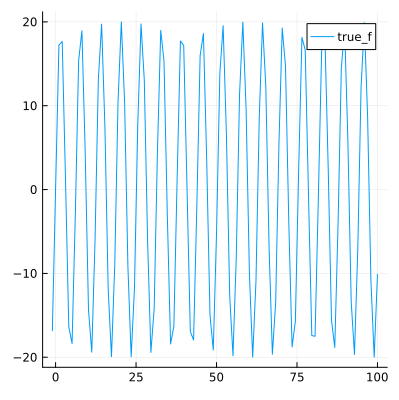

In [77]:

basis_functions = [+, -, *, /, sin, cos, EO.square, EO.cube, EO.logaritmus]
basis_variables = Vector{Any}([#= 2., 1., 0.,  =#:var1#= , :var2 =#])
# symbols are expected to be supplied as arguments to the trained model (in alphabetical order of the symbols)
# model = EO.Expr_parser(solution.top_coords);
# ŷ = model(var1);

#true_f = x -> x*cos(20*x) + x + 10*sin(x)
#true_f = x -> x*cos(x) + x + sin(x)
#true_f = x -> x^5 - 2*x^3 + x
true_f = x -> 20*sin(x)
#true_f = (x, x2) -> x + x2 + 123
#true_f = (x, x2) -> x*cos(x2)

x = collect(LinRange(-1., 100., 100))
y = true_f.(x);

#f(a, b) = a*cos(b)

#= x = collect(2:1:102)
data = CSV.read("../trading_data/archive(4)/sp500_stocks.csv", DataFrame)
price = filter("Symbol" => x->x == "EA", data).Open
y = float.(price[x]) =#
x = float.(x)

plot(x, y, label="true_f", size=(400, 400))
#plot(x, x2, f, label="true_f", size=(400, 400), st=:surface)


In [78]:
pop_size = 300

#objective_function  = enclose_arguments(EO.f_function_diff_subset, x, y, 0.9)
objective_function  = enclose_arguments(EO.f_function_diff_squared, y, x)
initialization      = enclose_noargs(EO.expression_initialization, pop_size, objective_function, basis_functions, basis_variables)
selection           = enclose_arguments(EO.s_tournament, 100, 3)
#selection           = enclose_arguments(EO.s_greedy_overselection, pop_size, 0.16)
crossover           = enclose_arguments(EO.cr_subtree, pop_size, basis_functions, basis_variables)
#crossover           = enclose_arguments(EO.cr_GSGP, pop_size, basis_functions, basis_variables)
mutation            = enclose_arguments(EO.subtree_mutation!, basis_functions, basis_variables)
replacement         = enclose_replacement(EO.r_best_n_diverse, pop_size, 0.7)       # chosen fraction of the population will consist of the best n, the rest is random
termination         = enclose_argument(iteration_termination, pop_size*20)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)

model = EO.Expr_parser(solution.top_coords);
println(model.(x))
println(y)
println(solution.top_coords)

[-16.72448630148591, 0.3947670354316668, 17.150419888522794, 17.58245085195939, 1.2117561180134615, -16.346070392514434, -18.326565783848615, -2.8231834166988756, 15.384685384367497, 18.927366391603464, 4.417621992645728, -14.311569369496222, -19.396932776379856, -5.983701250385165, 13.139838444683177, 19.73579485907861, 7.510778429207955, -11.879318262152479, -19.9431215699693, -8.988641054071088, 10.539293741364585, 20.01824246143511, 10.407479008522454, -9.129126451263367, -19.961064809202348, -11.757913142651606, 7.6584251638701355, 19.77222362275782, 13.03104028874526, -6.1370799383492, -19.453141855595003, -14.21848294283668, 4.575243778508622, 19.00605230340348, 15.312439134499867, -2.9832906107101396, -18.43399946413116, -16.305730399182497, 1.3717612160791708, 17.740828864111094, 17.19184670578665, 0.2486974769338933, -16.931167325506223, -17.964987615981627, -1.8673968882176588, 16.0103959785431, 18.620099169451066, 3.473673368739994, -14.984617074673478, -19.15290611648652, 

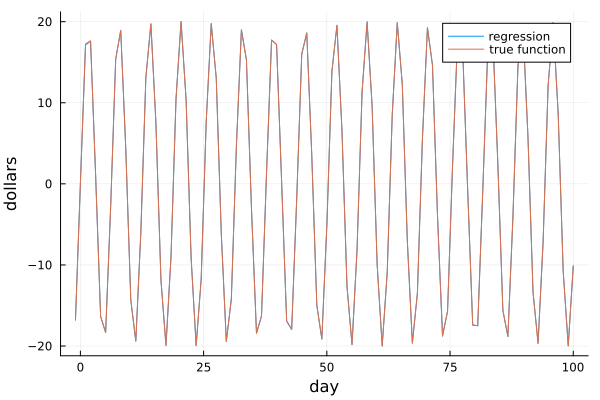

In [79]:
p = plot(x, model.(x), label="regression")
p = plot!(p, x, y, label="true function", xlabel="day", ylabel="dollars")
p

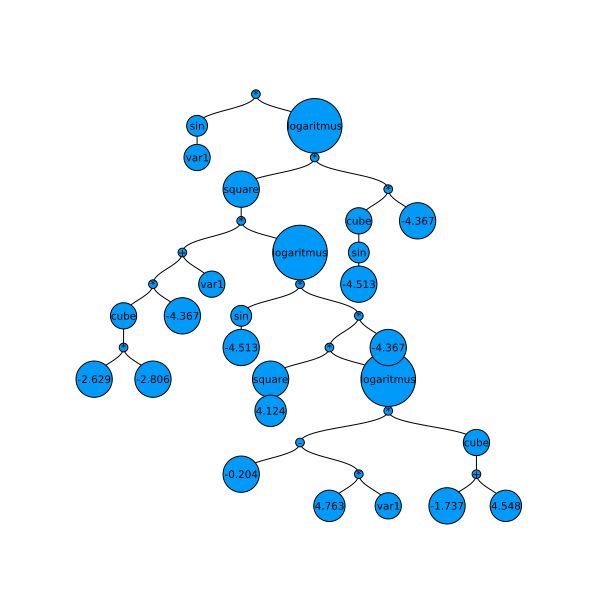

In [80]:
using GraphRecipes
plot(solution.top_coords, nodeshape=:circle, nodesize=0.1, size=(600, 600))

### Nested Evolutionary Feature Selection
(my own algorithm)

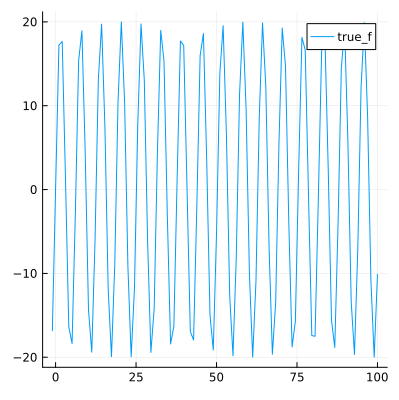

In [81]:
true_f = x -> 20*sin(x)

x = collect(LinRange(-1., 100., 100))
y = true_f.(x);

domain = float.(x)

plot(x, y, label="true_f", size=(400, 400))

In [82]:
variables = [domain]
#= operations = Vector{Function}([+, -, *, protected_div, sin, cos, square, cube, logaritmus, power])
arities =    [2,2,2,2,1,1, 1, 1, 1, 2] =#
operations = Vector{Function}([+, -, *, EO.protected_div, EO.sin, EO.square, EO.cube, EO.logaritmus])
arities =    [2,2,2,2,1,1,1,1]
exprs = Vector{Any}([:x])

best_model, models_hist = EO.feature_synthesis(y, variables, operations, arities, exprs, 10, q=10, μ=3, max_depth=10);

In [83]:
c = best_model.coefficients[:, end]
i = 1
for e in best_model.expressions
    println(round(c[i], digits=3), "\t * ", e)
    i = i +1
end

0.0	 * x
0.0	 * (EO.cube)(x)
19.417	 * (sin)(x)
0.0	 * (*)((sin)(x), x)
0.0	 * model at 1
0.0	 * (sin)("model at 1")
0.0	 * (EO.square)((sin)("model at 1"))
0.0	 * (sin)(x)


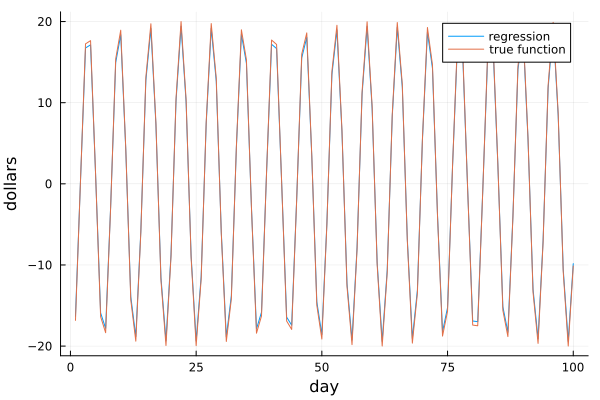

In [84]:
# prediction on the training data
features    = EO.extract_features(models_hist, float.(x))
maximal_value = maximum(y)+abs(maximum(y)-minimum(y))
minimal_value = minimum(y)-abs(maximum(y)-minimum(y))
prediction  = #= EO.denoise( =#EO.prediction(best_model, float.(x), features; λ=maximal_value, α=minimal_value)#= ) =#
p = plot(prediction, label="regression")
plot!(p, y, label="true function", xlabel="day", ylabel="dollars")
#savefig(p, "../images/NFS_regression.svg")
p